# Noise analysis

In [1]:
import argparse
import random
import sys
import yaml
from pathlib import Path
from typing import Any, Callable, Dict, Tuple, List

import numpy as np
from scipy.ndimage import shift
from skimage import exposure, io, registration, transform
from matplotlib import pyplot as plt
from scipy.stats import norm, t
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Utilities

In [2]:
def load_data_img_as_array(path: Path) -> np.ndarray:
    img = np.expand_dims(io.imread(path, as_gray=False), axis=2)
    img = np.clip(img, a_min=None, a_max=pow(2, 14))
    img = exposure.rescale_intensity(
        img, in_range='uint14', out_range=(0.0, 1.0))
    return img

In [3]:
def load_mask_img_as_array(path: Path) -> np.ndarray:
    img = io.imread(path)
    img = exposure.rescale_intensity(img, in_range=(0.0, 255.0), out_range=(0.0, 1.0))
    return img

In [4]:
def load_obj_from_repr_file(path) -> Any:
    with open(path, 'r') as file_:
        ret = eval(file_.readline())
    return ret

In [5]:
def draw_xy_histograms(xy_shifts: Tuple[List[float], List[float]]):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(xy_shifts[0], 100)
    plt.subplot(1, 2, 2)
    plt.hist(xy_shifts[1], 100)
    plt.tight_layout()
    plt.show()

## Noise analysis

In [6]:
probav_hr_xy_shifts = [[], []]
path = Path('../data/proba-v_registered_a')

img_diffs = []
limit = 10000
for i, hr_path in zip(tqdm(range(limit), position=0), path.glob('train/**/HR*.png')):
    hr = load_data_img_as_array(hr_path)
    lr_path = Path(str(hr_path).replace('HR', 'LR'))
    mask_path = Path(str(hr_path).replace('HR', 'QR'))
    lr = load_data_img_as_array(lr_path)
    lr_mask = load_mask_img_as_array(mask_path)
    hr_mask = transform.resize(lr_mask, hr.shape) > 0.5
    diff = hr - transform.resize(lr, hr.shape)
    img_diffs.append(diff[hr_mask])

 48%|████▊     | 4770/10000 [01:43<01:53, 46.01it/s]


In [7]:
all_pixels_diffs = np.concatenate(img_diffs).ravel()

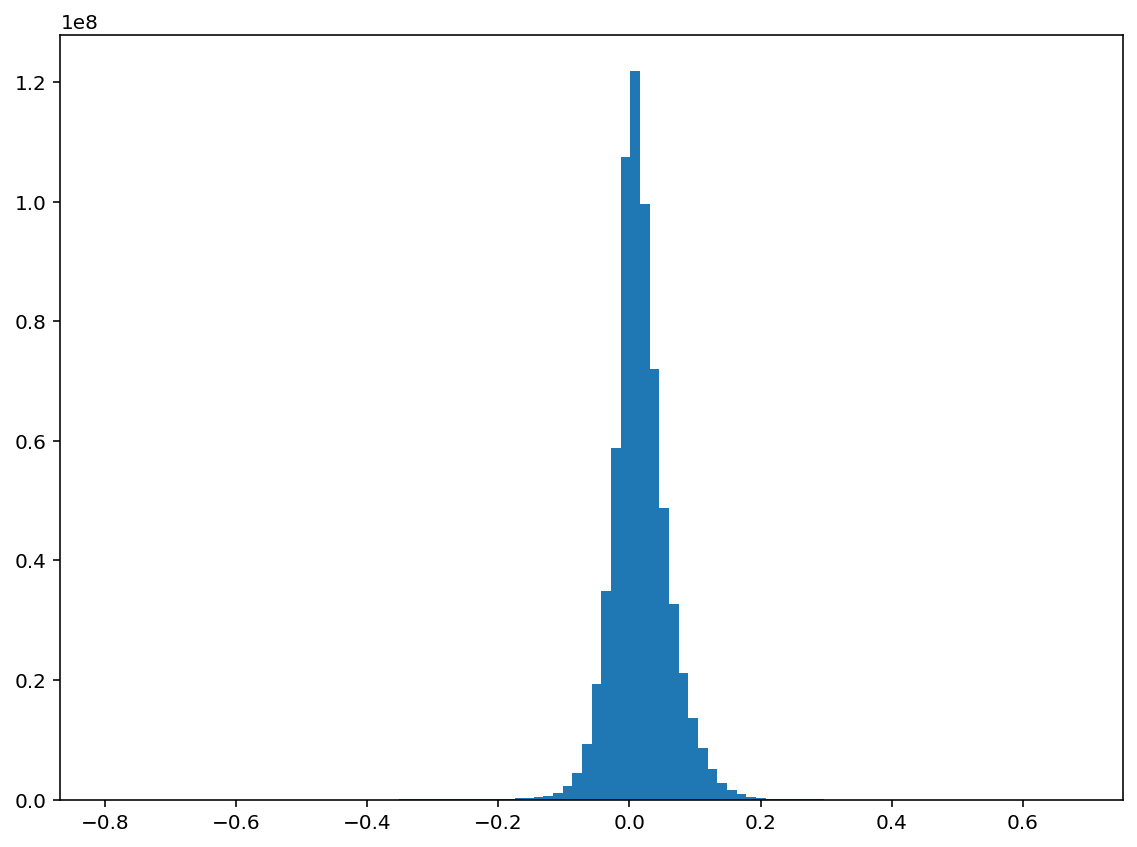

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(all_pixels_diffs, 100)
plt.tight_layout()
plt.show()

In [9]:
mean, std_dev = norm.fit(all_pixels_diffs)
mean, std_dev

(0.01654785003492425, 0.042961901229580775)

In [10]:
xmin, xmax = mean - 4 * std_dev, mean + 4 * std_dev

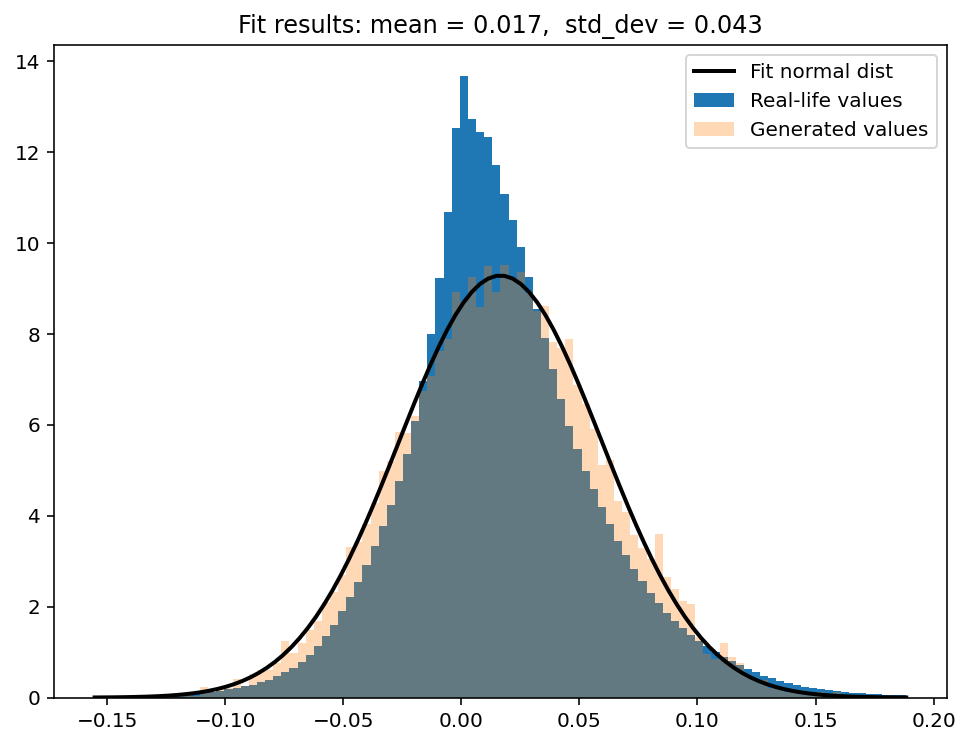

In [11]:
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
generated = np.random.normal(mean, std_dev, (10000, 1))

plt.figure(figsize=(8, 6))
plt.hist(all_pixels_diffs, 100, range=(xmin, xmax), density=True)
plt.hist(generated, 100, range=(xmin, xmax), density=True, alpha=0.3)
plt.plot(x, p, 'k', linewidth=2)
plt.title(f'Fit results: mean = {mean:.3f},  std_dev = {std_dev:.3f}')
plt.legend(('Fit normal dist', 'Real-life values', 'Generated values'))
plt.show()